## Подготовка.

In [1]:
import numpy as np
import pandas as pd

from JARVIS import Jarvis

from CONSTANTS import KEYS, MONTHS, YEARS, TARGET_COLUMN

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import SparsePCA

from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_validate

from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

In [2]:
sns.set_theme()

In [3]:
CV = TimeSeriesSplit()
SCORER = 'neg_root_mean_squared_error'

In [4]:
KEY = KEYS[0]
START_DATE = '2001-01-01'
EXP_DATE = '2022-12-15'

In [5]:
class Jarvis:
    """
    Jarvis class for fun and profit.
    
    This class compares data management, futures and options analisys features.
    Methods description follows.
    Backtesting is planned.
    """
    
    def __init__(self, name = None):
        self.PATH_WEB_1 = \
        'https://www.moex.com/ru/derivatives/contractresults-exp.aspx?day1=20000101&day2=20221230&code='
        self.PATH_WEB_2 = \
        'https://www.moex.com/ru/derivatives/contractresults-exp.aspx?type=2&day1=20000101&day2=20221230&code='
        self.PATH_LOCAL_FUTURES = 'FUTURES/'
        self.PATH_LOCAL_OPTIONS = 'OPTIONS/'
        self.COLUMNS = ['date', 'wavp', 'adjp', 'open', 'high', 'low', 'close', 'chng', 'lt_vol', 
                        'n_trades', 'vol_rub', 'vol_contr', 'oi_rub', 'oi_contr']
        self.TARGET_COLUMN = 'adjp'
        self.data = pd.DataFrame()
        if name:
            self.parse(name)
        
    #----ниже накладываем фичи на датафрейм
    def calc_rv(self, shift = 1):
        """
        Накладываем фичи реализованной волатильности.
        
        В целях предсказания делаем сдвиг фичей:
        """
        self.data['return'] = self.data[self.TARGET_COLUMN].shift(shift).pct_change() + 1
        self.data['return_5'] = self.data[self.TARGET_COLUMN].shift(shift).pct_change(periods = 5) + 1
        self.data['return_10'] = self.data[self.TARGET_COLUMN].shift(shift).pct_change(periods = 10) + 1
        self.data['return_20'] = self.data[self.TARGET_COLUMN].shift(shift).pct_change(periods = 20) + 1
        self.data['return_40'] = self.data[self.TARGET_COLUMN].shift(shift).pct_change(periods = 40) + 1
        self.data['return_60'] = self.data[self.TARGET_COLUMN].shift(shift).pct_change(periods = 60) + 1
        self.data['ln_r'] = np.log(self.data['return'])
        self.data['volatility_5'] = self.data['ln_r'].rolling(5).std(ddof = 1) * 100 * np.sqrt(260)
        self.data['volatility_20'] = self.data['ln_r'].rolling(20).std(ddof = 1) * 100 * np.sqrt(260)
        self.data['volatility_60'] = self.data['ln_r'].rolling(60).std(ddof = 1) * 100 * np.sqrt(260)

    def movings(self, n = 5, shift = 1):
        """
        Накладываем мувинги датафрейм.
        
        Параметры:
        n - период усреднения, обязательный параметр, по умолчанию равен пяти.
        shift - сдвиг назад: в целях расечта предсказательных моделей необходимо добовалять в целях
                предотвращения утечки целевого признака, в обзорных целях нагляднее не применять сдвиг.
                по умолчанию сдвиг равен единице.
        """
        self.data['mov_{}'.format(n)] = self.data[self.TARGET_COLUMN].shift(shift).rolling(n).mean()
            
    def lags(self):
        """
        Эта функция накладывает лаги цены.
        """
        self.data['lag_1'] = self.data[self.TARGET_COLUMN].shift(1)
        self.data['lag_2'] = self.data[self.TARGET_COLUMN].shift(2)
        self.data['lag_3'] = self.data[self.TARGET_COLUMN].shift(3)
        self.data['lag_5'] = self.data[self.TARGET_COLUMN].shift(5)
        self.data['lag_10'] = self.data[self.TARGET_COLUMN].shift(10)
        self.data['lag_20'] = self.data[self.TARGET_COLUMN].shift(20)
        self.data['lag_40'] = self.data[self.TARGET_COLUMN].shift(40)
        self.data['lag_60'] = self.data[self.TARGET_COLUMN].shift(60)

    def diffs(self):
        """
        Эта функция накладывает разницу цены.
        """
        self.data['dif_1'] = self.data[self.TARGET_COLUMN] - self.data[self.TARGET_COLUMN].shift(1)
        self.data['dif_2'] = self.data[self.TARGET_COLUMN] - self.data[self.TARGET_COLUMN].shift(2)
        self.data['dif_3'] = self.data[self.TARGET_COLUMN] - self.data[self.TARGET_COLUMN].shift(3)
        self.data['dif_5'] = self.data[self.TARGET_COLUMN] - self.data[self.TARGET_COLUMN].shift(5)
        self.data['dif_10'] = self.data[self.TARGET_COLUMN] - self.data[self.TARGET_COLUMN].shift(10)
        self.data['dif_20'] = self.data[self.TARGET_COLUMN] - self.data[self.TARGET_COLUMN].shift(20)
        self.data['dif_40'] = self.data[self.TARGET_COLUMN] - self.data[self.TARGET_COLUMN].shift(40)
        self.data['dif_60'] = self.data[self.TARGET_COLUMN] - self.data[self.TARGET_COLUMN].shift(60)

    def calendar_features(self):
        """
        Эта функция накладывает календарные фичи.
        """
        # константа и тренд
        self.data['const'] = np.ones(self.data.shape[0])
        self.data['time_step'] = np.arange(len(self.data.index))
        # сезонность
        self.data['year'] = self.data.index.year
        self.data['month'] = self.data.index.month
        self.data['day'] = self.data.index.day
        self.data['day_of_week'] = self.data.index.dayofweek
        self.data['sin_month'] = np.sin(2 * np.pi * self.data.index.month / 12)
        self.data['cos_month'] = np.cos(2 * np.pi * self.data.index.month / 12)
        self.data['sin_day'] = np.sin(2 * np.pi * self.data.index.day / (365/12))
        self.data['cos_day'] = np.cos(2 * np.pi * self.data.index.day / (365/12))
        self.data['sin_dw'] = np.sin(2 * np.pi * self.data.index.dayofweek / 4)
        self.data['cos_dw'] = np.cos(2 * np.pi * self.data.index.dayofweek / 4)
    
    #----ниже блок загрузк файлов
    def get_variables(self, name):
        futname = ''
        try:
            futname = name.split('-')[0]
        except:
            pass
        if len(name) > 10:
            path = self.PATH_LOCAL_OPTIONS
        else:
            path = self.PATH_LOCAL_FUTURES
        return futname, path

    def parse_csv(self, name, parse_from, datetime_format):
        "Парсим цсв (внезапно)."
        
        x = pd.DataFrame()
        result = {}
        result['name'] = name
        try:
            x = pd.read_csv(parse_from, encoding='cp866')
            try:
                x.columns = self.COLUMNS
                result['columns'] = True
            except:
                result['columns'] = False
            try:
                x['date'] = pd.to_datetime(x['date'], format = datetime_format)
                result['to_datetime'] = True
            except:
                result['to_datetime'] = False
            try:
                x = x.sort_values(by = 'date')
                result['sort_values'] = True
            except:
                result['sort_values'] = False
            try:
                x.set_index('date', inplace = True)
                result['set_index'] = True
            except:
                result['set_index'] = False
            result['read_scv'] = True
        except:
            result['read_scv'] = False
        return result, x

    def local(self, name, futname, path):
        "Качаем дату с локальной папки (по умолчанию)."
        
        parse_from = (path + futname + '/' + name + '.csv')
        datetime_format = '%Y.%m.%d'
        result, x = self.parse_csv(name, parse_from, datetime_format)
        return result, x

    def web(self, name, futname, path):
        "Качаем дату с сайта."
        
        parse_from = (self.PATH_WEB_1 + name)
        datetime_format = '%d.%m.%Y'
        result, x = self.parse_csv(name, parse_from, datetime_format)
        if result['read_scv']:
            try:
                x.to_csv(path + futname + '/' + name + '.csv')
            except:
                print(name, 'no save')
        return result, x

    def parse(self, name):
        """
        argument name as follows: RTS-3.22, RTS-12.22M150922CA100000 (no .csv extension)
        """
        
        if not self.data.empty:
            print('этот датафрейм уже заполнен')
        if self.data.empty:
            self.name = name
            futname, path = self.get_variables(name)
            result, self.data = self.local(name, futname, path)
            result['parse_local'] = True
            self.parse_log = result
            if not result['read_scv']:
                result, self.data = self.web(name, futname, path)
                result['parse_local'] = False
                self.parse_log = result
    
    #----ниже расчет значений по формуле Б-Ш
    def d1_calc(self, spot, strike, sigma, T):
        result = (log(spot/strike) + 0.5 * (sigma ** 2) * (T)) / (sigma * sqrt(T))
        return result

    def n_d1_calc(self, d1):
        result = (1 / sqrt(2 * pi)) * exp(-0.5 * (d1 ** 2))
        return result

    def price(self, spot, strike, sigma, T, option_type):
        d1 = self.d1_calc(spot, strike, sigma, T)
        d2 = d1 - sigma * sqrt(T)
        if option_type == 'call':
            N_d2 = norm.cdf(d2)
            delta_call = norm.cdf(d1)
            result = (spot * delta_call - strike * N_d2)
        if option_type == 'put':
            N_minus_d2 = norm.cdf(-d2)
            delta_put = (norm.cdf(d1) - 1)
            result = (strike * N_minus_d2 + spot * delta_put)
        return result

    def delta(self, spot, strike, sigma, T, option_type):
        d1 = self.d1_calc(spot, strike, sigma, T)
        delta_call = norm.cdf(d1)
        if option_type == 'call':
            result = delta_call
        if option_type == 'put':
            result = (delta_call - 1)
        return result

    def gamma(self, spot, strike, sigma, T):
        d1 = self.d1_calc(spot, strike, sigma, T)
        n_d1 = self.n_d1_calc(d1)
        result = n_d1 / (sigma * spot * sqrt(T))
        return result

    def theta(self, spot, strike, sigma, T):
        d1 = self.d1_calc(spot, strike, sigma, T)
        n_d1 = self.n_d1_calc(d1)
        result = (-spot * n_d1 * sigma / (2 * sqrt(T))) / 365
        return result

    def vega(self, spot, strike, sigma, T):
        d1 = self.d1_calc(spot, strike, sigma, T)
        n_d1 = self.n_d1_calc(d1)
        result = spot * sqrt(T) * n_d1 / 100
        return result

    #--------ниже подбор волатильности
    def loss_func(self, spot, strike, T, option_type, sigma, premium):
        "Ф-ия потерь: в данном случае сравнением расчетной премии с фактической."
        return self.price(spot, strike, sigma, T, option_type) - premium

    def compute_iv(self, spot, strike, T, option_type, premium):
        "Функция итеративного поиска значения подразумеваемой волатильности."

        if T == 0:
            return 0

        left = 0.01
        right = 10
        error = 0.000001

        while right - left > error:
            if self.loss_func(spot, strike, T, option_type, left, premium) == 0:
                return left
            middle = (left + right) / 2
            if self.loss_func(spot, strike, T, option_type, left, premium) * \
            self.loss_func(spot, strike, T, option_type, middle, premium) < 0:
                right = middle
            else:
                left = middle
        return left
    
    def info(self):
        try:
            print('Name:', self.name)
        except:
            pass
        try:
            print('Parse_log:', self.parse_log)
        except:
            pass
        print('Head:')
        display(self.data.head())
        print('Tail:')
        display(self.data.tail())
        print('Info:')
        print(self.data.info())
        print('Missings:')
        print(self.data.isna().sum().sort_values(ascending = False))
        print('Monotonic:')
        print(self.data.index.is_monotonic)
        print('Describe:')
        display(self.data.describe())
        print('-----')
        
# d:^{|

## Загрузка

In [6]:
data = Jarvis()
data.name = 'RTS'

In [7]:
load_results = []

In [8]:
for year in YEARS:
    for month in MONTHS:
        name = KEY + '-' + month + '.' + year
        try:
            df = Jarvis(name)
            load_results.append(df.parse_log)
        except:
            pass
        try:
            df.data.index = df.data.index.to_period("D")
        except:
            pass
        try:
            df.data = df.data[[TARGET_COLUMN]]
        except:
            pass
        try:
            df.data['name'] = name
        except:
            pass
        try:
            df.lags()
            df.movings(5)
            df.movings(10)
            df.movings(20)
            df.movings(40)
            df.calc_rv()
        except:
            pass
        try:
            df.data = df.data[START_DATE:]
        except:
            pass
        try:
            START_DATE = str(df.data.index[df.data.shape[0]-1].year) + '-' + \
            str(df.data.index[df.data.shape[0]-1].month) \
            + '-' + str(df.data.index[df.data.shape[0]-1].day+1)
        except:
            pass
        try:
            data.data = pd.concat([data.data, df.data])
        except:
            pass

## Проверка

In [9]:
x = pd.DataFrame(load_results)

In [10]:
x = x.fillna(0)

In [11]:
x.head()

,name,read_scv,parse_local,columns,to_datetime,sort_values,set_index
0,RTS-3.01,False,False,0,0,0,0
1,RTS-6.01,False,False,0,0,0,0
2,RTS-9.01,False,False,0,0,0,0
3,RTS-12.01,False,False,0,0,0,0
4,RTS-3.02,False,False,0,0,0,0


In [12]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         88 non-null     object
 1   read_scv     88 non-null     bool  
 2   parse_local  88 non-null     bool  
 3   columns      88 non-null     object
 4   to_datetime  88 non-null     object
 5   sort_values  88 non-null     object
 6   set_index    88 non-null     object
dtypes: bool(2), object(5)
memory usage: 3.7+ KB


In [13]:
x[x['read_scv']]['name'].unique()

array(['RTS-9.05', 'RTS-12.05', 'RTS-3.06', 'RTS-6.06', 'RTS-9.06',
       'RTS-12.06', 'RTS-3.07', 'RTS-6.07', 'RTS-9.07', 'RTS-12.07',
       'RTS-3.08', 'RTS-6.08', 'RTS-9.08', 'RTS-12.08', 'RTS-3.09',
       'RTS-6.09', 'RTS-9.09', 'RTS-12.09', 'RTS-3.10', 'RTS-6.10',
       'RTS-9.10', 'RTS-12.10', 'RTS-3.11', 'RTS-6.11', 'RTS-9.11',
       'RTS-12.11', 'RTS-3.12', 'RTS-6.12', 'RTS-9.12', 'RTS-12.12',
       'RTS-3.13', 'RTS-6.13', 'RTS-9.13', 'RTS-12.13', 'RTS-3.14',
       'RTS-6.14', 'RTS-9.14', 'RTS-12.14', 'RTS-3.15', 'RTS-6.15',
       'RTS-9.15', 'RTS-12.15', 'RTS-3.16', 'RTS-6.16', 'RTS-9.16',
       'RTS-12.16', 'RTS-3.17', 'RTS-6.17', 'RTS-9.17', 'RTS-12.17',
       'RTS-3.18', 'RTS-6.18', 'RTS-9.18', 'RTS-12.18', 'RTS-3.19',
       'RTS-6.19', 'RTS-9.19', 'RTS-12.19', 'RTS-3.20', 'RTS-6.20',
       'RTS-9.20', 'RTS-12.20', 'RTS-3.21', 'RTS-6.21', 'RTS-9.21',
       'RTS-12.21', 'RTS-3.22', 'RTS-6.22', 'RTS-9.22', 'RTS-12.22'],
      dtype=object)

In [14]:
x[x['read_scv']].drop(['name'], axis = 1).mean() * 100

read_scv       100.0
parse_local    100.0
columns        100.0
to_datetime    100.0
sort_values    100.0
set_index      100.0
dtype: float64

In [15]:
data.data = data.data.iloc[60:,:]

In [16]:
data.calendar_features()

In [17]:
data.info()

Name: RTS
Head:


,name,adjp,lag_1,lag_2,lag_3,lag_5,lag_10,lag_20,lag_40,lag_60,...,year,month,day,day_of_week,sin_month,cos_month,sin_day,cos_day,sin_dw,cos_dw
2005-10-26,RTS-12.05,91050.0,90550.0,91300.0,89800.0,88360.0,95560.0,96850.0,87600.0,82240.0,...,2005,10,26,2,-0.866025,0.500000,-0.790946,0.611886,1.224647e-16,-1.000000e+00
2005-10-27,RTS-12.05,89290.0,91050.0,90550.0,91300.0,88600.0,92600.0,97000.0,89070.0,81270.0,...,2005,10,27,3,-0.866025,0.500000,-0.648630,0.761104,-1.000000e+00,-1.836970e-16
2005-10-28,RTS-12.05,91750.0,89290.0,91050.0,90550.0,89800.0,89525.0,98100.0,90300.0,82090.0,...,2005,10,28,4,-0.866025,0.500000,-0.478734,0.877960,-2.449294e-16,1.000000e+00
2005-10-31,RTS-12.05,94000.0,91750.0,89290.0,91050.0,91300.0,90400.0,100920.0,90450.0,82600.0,...,2005,10,31,0,-0.866025,0.500000,0.120208,0.992749,0.000000e+00,1.000000e+00
2005-11-01,RTS-12.05,94740.0,94000.0,91750.0,89290.0,90550.0,90320.0,101250.0,88220.0,83275.0,...,2005,11,1,1,-0.500000,0.866025,0.205104,0.978740,1.000000e+00,6.123234e-17


Tail:


,name,adjp,lag_1,lag_2,lag_3,lag_5,lag_10,lag_20,lag_40,lag_60,...,year,month,day,day_of_week,sin_month,cos_month,sin_day,cos_day,sin_dw,cos_dw
2022-12-09,RTS-12.22,109890.0,109720.0,110160.0,109750.0,110690.0,113330.0,114460.0,98800.0,115480.0,...,2022,12,9,4,-2.449294e-16,1.0,0.958718,-0.284359,-2.449294e-16,1.000000e+00
2022-12-12,RTS-12.22,109130.0,109890.0,109720.0,110160.0,111630.0,111700.0,115350.0,99010.0,115810.0,...,2022,12,12,0,-2.449294e-16,1.0,0.615285,-0.788305,0.000000e+00,1.000000e+00
2022-12-13,RTS-12.22,109050.0,109130.0,109890.0,109720.0,109750.0,112670.0,113780.0,103810.0,116740.0,...,2022,12,13,1,-2.449294e-16,1.0,0.440519,-0.897743,1.000000e+00,6.123234e-17
2022-12-14,RTS-12.22,106740.0,109050.0,109130.0,109890.0,110160.0,112140.0,115060.0,103550.0,107480.0,...,2022,12,14,2,-2.449294e-16,1.0,0.247022,-0.969010,1.224647e-16,-1.000000e+00
2022-12-15,RTS-12.22,103915.0,106740.0,109050.0,109130.0,109720.0,111970.0,113700.0,102040.0,103800.0,...,2022,12,15,3,-2.449294e-16,1.0,0.043022,-0.999074,-1.000000e+00,-1.836970e-16


Info:
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 4300 entries, 2005-10-26 to 2022-12-15
Freq: D
Data columns (total 36 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           4300 non-null   object 
 1   adjp           4300 non-null   float64
 2   lag_1          4300 non-null   float64
 3   lag_2          4300 non-null   float64
 4   lag_3          4300 non-null   float64
 5   lag_5          4300 non-null   float64
 6   lag_10         4300 non-null   float64
 7   lag_20         4300 non-null   float64
 8   lag_40         4300 non-null   float64
 9   lag_60         4294 non-null   float64
 10  mov_5          4300 non-null   float64
 11  mov_10         4300 non-null   float64
 12  mov_20         4300 non-null   float64
 13  mov_40         4300 non-null   float64
 14  return         4300 non-null   float64
 15  return_5       4300 non-null   float64
 16  return_10      4300 non-null   float64
 17  return_20      4300 no

,adjp,lag_1,lag_2,lag_3,lag_5,lag_10,lag_20,lag_40,lag_60,mov_5,...,year,month,day,day_of_week,sin_month,cos_month,sin_day,cos_day,sin_dw,cos_dw
count,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4300.000000,4294.000000,4300.000000,...,4300.000000,4300.000000,4300.000000,4300.000000,4.300000e+03,4.300000e+03,4300.000000,4300.000000,4.300000e+03,4.300000e+03
mean,134088.878605,134064.272093,134042.946512,134019.560465,133974.430233,133867.946512,133688.686047,133356.448837,132967.406847,134019.538140,...,2013.910465,6.655581,16.020233,2.030698,-2.394454e-02,-3.591829e-03,-0.018236,-0.011268,2.790698e-03,1.888372e-01
std,36854.328574,36863.689224,36876.050474,36889.844229,36915.850586,36976.690765,37086.827258,37327.618683,37471.999099,36798.446798,...,4.949161,3.422859,8.714158,1.420610,7.088374e-01,7.051211e-01,0.704983,0.709064,6.369207e-01,7.475888e-01
min,47700.000000,47700.000000,47700.000000,47700.000000,47700.000000,47700.000000,47700.000000,47850.000000,47850.000000,49875.000000,...,2005.000000,1.000000,1.000000,0.000000,-1.000000e+00,-1.000000e+00,-0.999250,-0.999074,-1.000000e+00,-1.000000e+00
25%,109375.000000,109330.000000,109265.000000,109265.000000,109172.500000,108915.000000,108360.000000,107380.000000,107092.500000,109505.250000,...,2010.000000,4.000000,9.000000,1.000000,-8.660254e-01,-5.000000e-01,-0.705584,-0.708627,-2.449294e-16,-1.836970e-16
50%,131485.000000,131390.000000,131330.000000,131300.000000,131225.000000,131080.000000,130905.000000,130632.500000,130275.000000,131588.500000,...,2014.000000,7.000000,16.000000,2.000000,-2.449294e-16,-1.836970e-16,-0.085965,0.038722,0.000000e+00,6.123234e-17
75%,155801.250000,155801.250000,155801.250000,155750.000000,155690.000000,155626.250000,155400.000000,154856.250000,153990.000000,155232.000000,...,2018.000000,10.000000,24.000000,3.000000,5.000000e-01,5.000000e-01,0.735417,0.677615,1.224647e-16,1.000000e+00
max,248900.000000,248900.000000,248900.000000,248900.000000,248900.000000,248900.000000,251310.000000,251310.000000,251310.000000,245736.000000,...,2022.000000,12.000000,31.000000,6.000000,1.000000e+00,1.000000e+00,0.996659,0.996298,1.000000e+00,1.000000e+00


-----


<AxesSubplot:>

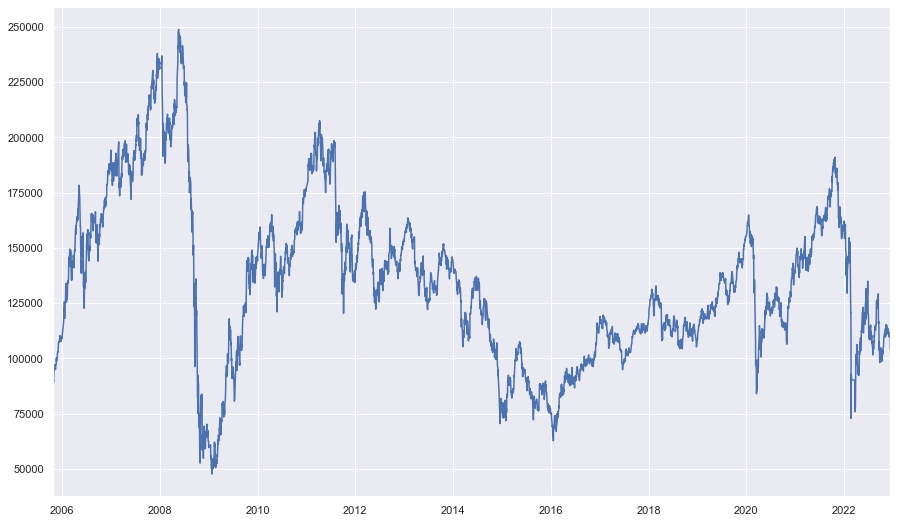

In [18]:
data.data[TARGET_COLUMN].plot(figsize = (15, 9))

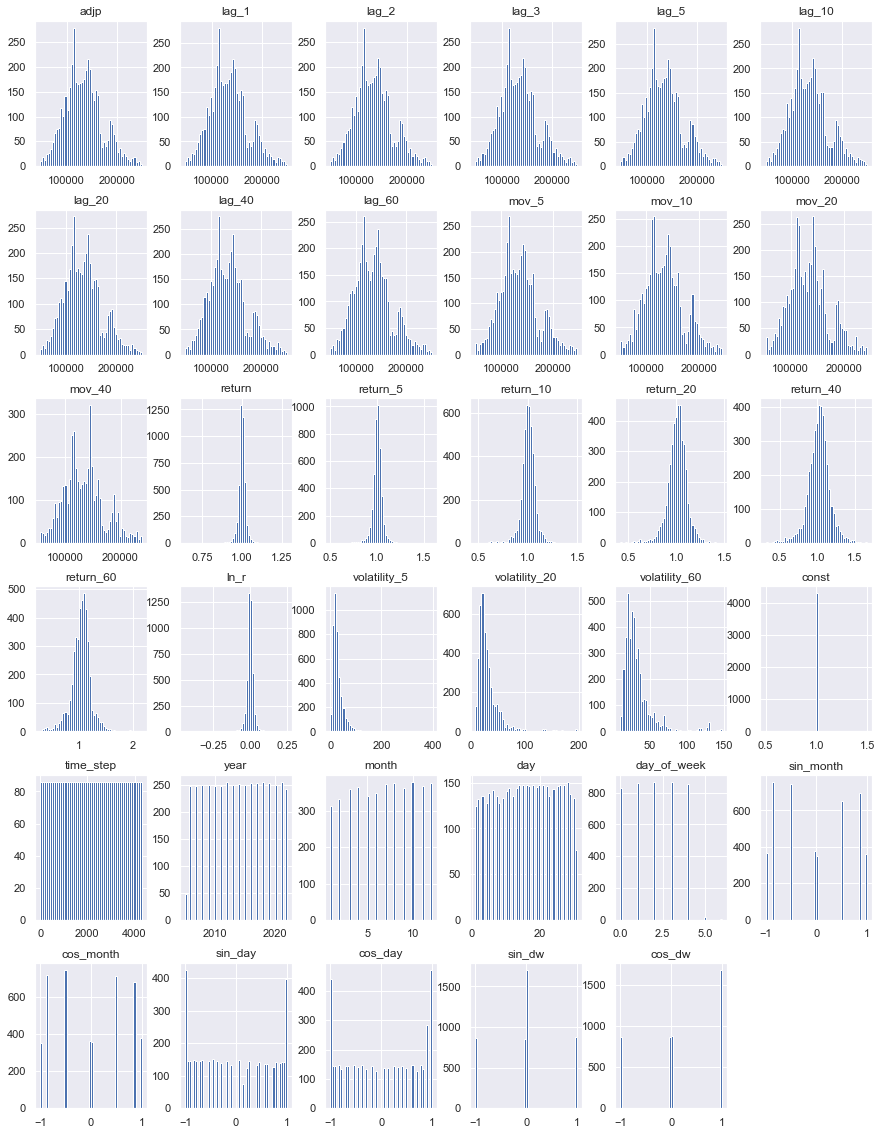

In [19]:
data.data.hist(bins = 50, figsize = (15, 20))
plt.show()

## Ансамбль

In [20]:
TEST_SIZE = 0.05

In [21]:
y = data.data[TARGET_COLUMN].dropna()
X = data.data.drop(['name', TARGET_COLUMN], axis = 1).dropna()
y, X = y.align(X, join='inner', axis = 0)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, shuffle = False)

In [23]:
X_train.columns

Index(['lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_10', 'lag_20', 'lag_40',
       'lag_60', 'mov_5', 'mov_10', 'mov_20', 'mov_40', 'return', 'return_5',
       'return_10', 'return_20', 'return_40', 'return_60', 'ln_r',
       'volatility_5', 'volatility_20', 'volatility_60', 'const', 'time_step',
       'year', 'month', 'day', 'day_of_week', 'sin_month', 'cos_month',
       'sin_day', 'cos_day', 'sin_dw', 'cos_dw'],
      dtype='object')

In [24]:
cat_cols = ['year', 'month', 'day', 'day_of_week']
num_cols = ['lag_1', 'lag_2', 'lag_3', 'lag_5', 'lag_10', 'lag_20', 'lag_40', 'lag_60',
            'mov_5', 'mov_10', 'mov_20', 'mov_40', 'mov_60',
            'return', 'return_5', 'return_10', 'return_20', 'return_40', 'return_60',
            'ln_r', 'volatility_5', 'volatility_20', 'volatility_60',
            'const', 'time_step',
            'sin_month', 'cos_month', 'sin_day', 'cos_day', 'sin_dw', 'cos_dw']

In [25]:
cat_transformer = OneHotEncoder(drop='first', handle_unknown='ignore')

In [26]:
num_transformer = StandardScaler()

In [27]:
clmns_trnsfrmr = ColumnTransformer([('cat_tr', cat_transformer, cat_cols),
                                    ('num_trf', num_transformer, num_cols)], sparse_threshold = 0)

In [28]:
pca = SparsePCA()

In [29]:
preprocessor = Pipeline(steps = [('clnm_trnsfrm', clmns_trnsfrmr), ('pca', pca)])

In [30]:
class lmgb_ansamble:
    
    def __init__(self):
        self.preds_model_ = LinearRegression()
        self.resids_model_ = XGBRegressor()
                
    def fit(self, X_, y_):
        self.preds_model_.fit(X_, y_)
        preds_ = self.preds_model_.predict(X_)
        resids_ = (y_ - preds_)
        self.resids_model_.fit(X_, resids_)
        
    def perdict(self, X_):
        predictions_ = pd.Series(self.preds_model_.predict(X_), index = X_.index,
                                     name = 'preds')
        residuals_ = pd.Series(self.resids_model_.predict(X_), index = X_.index,
                                   name = 'resids')
        
        return predictions_, residuals_

In [31]:
la = lmgb_ansamble()

In [32]:
la.fit(X_train, y_train)

In [33]:
preds, resids = la.perdict(X_test)

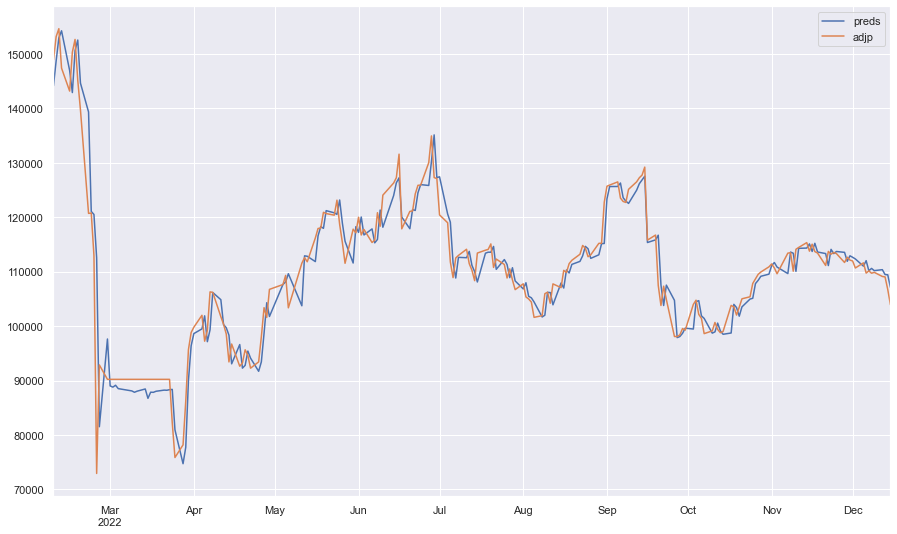

In [34]:
f, ax = plt.subplots(figsize = (15, 9))
preds.plot(ax = ax, legend = True)
y_test.plot(ax = ax, legend = True)
plt.show()

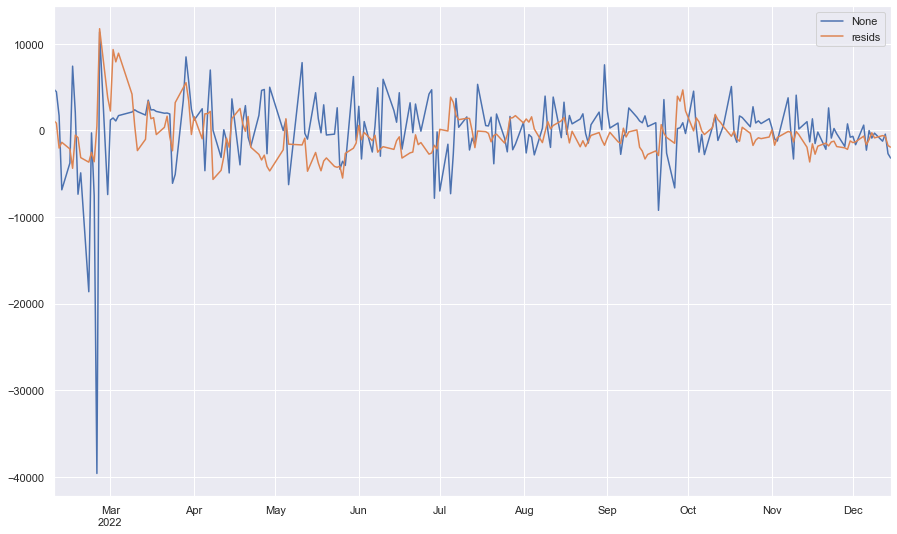

In [35]:
f, ax = plt.subplots(figsize = (15, 9))
(y_test - preds).plot(ax = ax, legend = True)
(resids).plot(ax = ax, legend = True)
plt.show()

In [36]:
(y_test - preds).describe()

count      215.000000
mean         9.916455
std       4367.523250
min     -39618.338193
25%      -1420.569763
50%        304.204183
75%       2034.556959
max      11355.790337
dtype: float64

In [37]:
(resids).describe()

count      215.000000
mean      -510.032745
std       2413.903320
min      -5664.672363
25%      -1917.713562
50%       -812.978333
75%        548.094727
max      11740.673828
Name: resids, dtype: float64

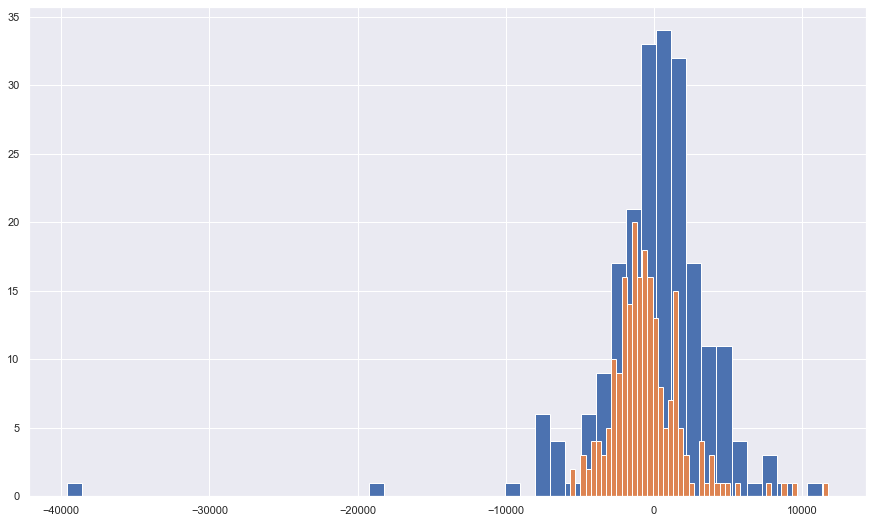

In [38]:
f, ax = plt.subplots()
(y_test - preds).hist(bins = 50, figsize = (15, 9), ax = ax, density=0)
(resids).hist(bins = 50, figsize = (15, 9), ax = ax, density=0)
plt.show()

In [39]:
mean_squared_error(y_test, preds) ** 0.5

4357.365664946142

In [40]:
mean_squared_error((y_test - preds), resids) ** 0.5

4720.137741793401

In [41]:
r2_score(y_test, preds)

0.8971653770541795

In [42]:
r2_score((y_test - preds), resids)

-0.17344727290217388

Простая линейная регрессия

In [43]:
base = LinearRegression()
base.fit(X_train, y_train)

LinearRegression()

In [44]:
train_base_preds = base.predict(X_train)

In [45]:
train_base_resids = pd.Series(y_train - train_base_preds)

/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='month'>

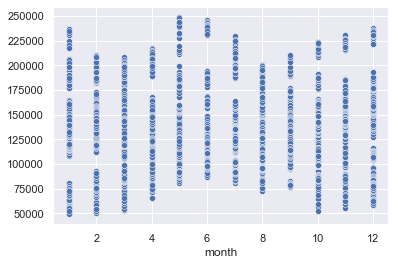

In [46]:
sns.scatterplot(X_train['month'], train_base_preds)

In [47]:
base_preds = pd.DataFrame(base.predict(X_test), index = y_test.index, columns = ['preds'])

In [48]:
mean_squared_error(y_test, base_preds)**0.5

4357.365664946142

In [49]:
r2_score(y_test, base_preds)

0.8971653770541795

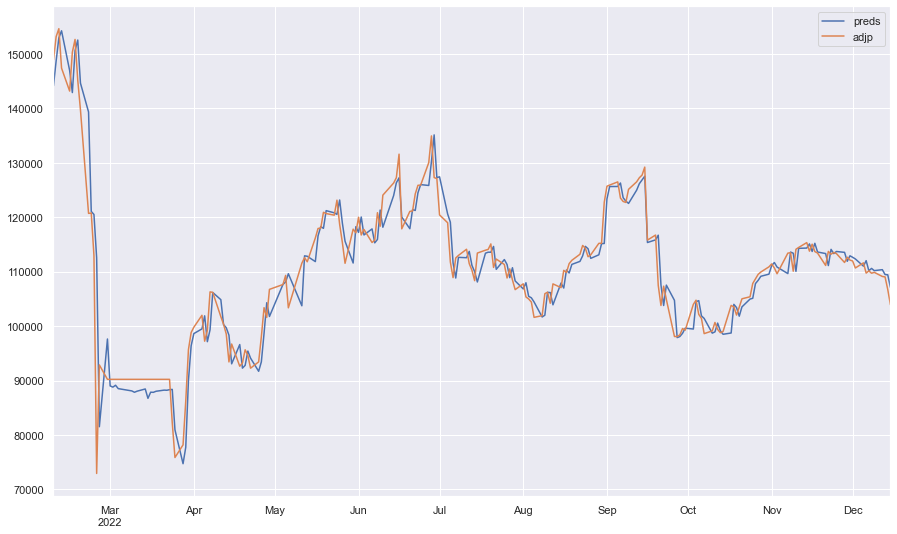

In [50]:
f, ax = plt.subplots(figsize = (15, 9))
base_preds.plot(ax = ax, legend = True)
y_test.plot(ax = ax, legend = True)
plt.show()